# Project 2 : Two dimentional Ising model

In [1]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skms
import sklearn.linear_model as skl
import sklearn.metrics as skm
import tqdm
import copy
import time
from IPython.display import display

%matplotlib inline

sns.set(color_codes=True)

import algorithms

In [2]:
cwd = os.getcwd()
filenames = glob.glob(os.path.join(cwd, 'files*'))

In [3]:
label_filename = "/home/hanna/project2/files/Ising2DFM_reSample_L40_T=All_labels.pkl"

# Read in the labels
with open(label_filename, "rb") as f:
    labels = pickle.load(f)

dat_filename = "/home/hanna/project2/files/Ising2DFM_reSample_L40_T=All.pkl"
    
# Read in the corresponding configurations
with open(dat_filename, "rb") as f:
    data = np.unpackbits(pickle.load(f)).reshape(-1, 1600).astype("int")

# Set spin-down to -1
data[data == 0] = -1

In [4]:
data.shape

(160000, 1600)

In [5]:
# Set up slices of the dataset
ordered = slice(0, 70000)
critical = slice(70000, 100000)
disordered = slice(100000, 160000)

X = np.concatenate((data[ordered], data[disordered]))
Y = np.concatenate((labels[ordered], labels[disordered]))

In [6]:
labels[ordered].shape, labels[disordered].shape

((70000,), (60000,))

In [7]:
data[ordered].shape, data[disordered].shape

((70000, 1600), (60000, 1600))

In [8]:
Y.shape

(130000,)

In [9]:
data[disordered]

array([[ 1,  1, -1, ..., -1,  1,  1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ...,  1, -1, -1],
       [ 1,  1,  1, ...,  1, -1, -1]])

In [10]:
X.shape

(130000, 1600)

In [11]:
X_train, X_test, y_train, y_test = skms.train_test_split(X,Y, test_size = 0.333)

In [12]:
from utils import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, split_size=0.5, random_state=0)

In [13]:
# Testing that y_test and train contain both label 
y_train, y_test

(array([1, 0, 0, ..., 1, 1, 1]), array([1, 1, 1, ..., 0, 0, 0]))

# Sammenlign med Stochastic gradient descent. 

In [ ]:
eta = 0.01
n_iter = 50
random_state = 1
key = "ols" 
lmd=0.01
descent_method= "sgd"
a = algorithms.LogisticRegression(eta, random_state, key, descent_method, n_iter, lmd)

# Sammenlign med Standard/steepest gradient descent

In [14]:
eta = 0.01
n_iter = 50
random_state = 1
key = "ols" 
lmd=0.01
# (self, eta, random_state, key, n_iter = 50, lmd = 0, tolerance=1e-14):
a = algorithms.LogisticRegression(eta, random_state, key, n_iter, lmd)

In [15]:
log = a.fit(X_train, y_train)

In [16]:
score = log.predict(X_test)

In [17]:
score

array([1, 1, 1, ..., 1, 1, 0])

In [18]:
acc = np.sum(score == y_test)/len(score)
acc

0.50126153846153843

In [19]:
# new ols 0.99189918991899195

# ridge lmd = 0.01 0.501950195019502
# ridge lmd = 0.001 0.89378937893789379
# ridge lmd = 0.0001 0.99099909990999102

# lasso lmd = 0.1 0.99009900990099009
# lasso lmd = 0.01 0.9924992499249925
# lasso lmd = 0.001 0.99279927992799277
# lasso lmd = 0.0001 0.99279927992799277

# eta = 0.01, lmd = 0.00 0.99579957995799584
# lmd 

In [20]:
accuracy = {"ols": [], "ridge":[], "lasso": []}

In [21]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
key = "lasso"
for e in eta:
    for l in lmd:
        a = algorithms.LogisticRegression(e, random_state, key, n_iter, l)
        log = a.fit(X_train, y_train)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        accuracy[key].append(acc)

In [22]:
accuracy["lasso"]

[0.49807692307692308,
 0.49824615384615384,
 0.49787692307692305,
 0.4982923076923077,
 0.49812307692307695,
 0.48310769230769229,
 0.49795384615384614,
 0.49786153846153847,
 0.50123076923076926,
 0.50150769230769232,
 0.5014153846153846,
 0.4636769230769231,
 0.49821538461538462,
 0.49775384615384616,
 0.49778461538461538,
 0.50163076923076921,
 0.49763076923076921,
 0.49607692307692308,
 0.49787692307692305,
 0.49961538461538463,
 0.50198461538461536,
 0.49743076923076923,
 0.50183076923076919,
 0.48824615384615383]

In [23]:
m = np.array(accuracy["lasso"]).reshape((len(eta), len(lmd)))
m

array([[ 0.49807692,  0.49824615,  0.49787692,  0.49829231,  0.49812308,
         0.48310769],
       [ 0.49795385,  0.49786154,  0.50123077,  0.50150769,  0.50141538,
         0.46367692],
       [ 0.49821538,  0.49775385,  0.49778462,  0.50163077,  0.49763077,
         0.49607692],
       [ 0.49787692,  0.49961538,  0.50198462,  0.49743077,  0.50183077,
         0.48824615]])

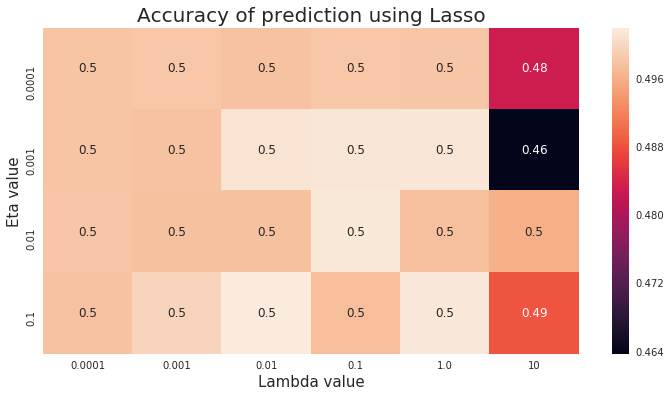

In [ ]:
m = np.array(accuracy["lasso"]).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Accuracy of prediction using Lasso", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15)
plt.savefig("./results/figures/Logisticregression_Lasso.png")

# OLS

In [ ]:
key = "ols"
etas = [0.0001, 0.001, 0.01, 0.1]

for e in etas:
    a = algorithms.LogisticRegression(e, random_state, key, n_iter)
    log = a.fit(X_train, y_train)
    score = log.predict(X_test)
    acc = np.sum(score == y_test)/len(score)
    accuracy[key].append(acc)

In [ ]:
m = np.array(accuracy[key])
print(m)
#np.array(m).reshape((4, 1))

In [ ]:
m = np.array(accuracy[key]).reshape(1,(len(eta)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=eta)
ax.set_title("Logistic regression OLS", fontsize = 20)
ax.set_xlabel("Eta value", fontsize = 15)
ax.set_ylabel("Lambda value (lmd=0)", fontsize = 15)
plt.savefig("./results/figures/Logisticregression_OLS.png")

# Ridge

In [ ]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

key = "ridge"

for e in eta:
    for l in lmd:
        a = algorithms.LogisticRegression(e, random_state, key, n_iter, l)
        log = a.fit(X_train, y_train)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        accuracy[key].append(acc)

In [ ]:
m = np.array(accuracy[key]).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Logistic regression Ridge", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15) #
plt.savefig("./results/figures/Logisticregression_Ridge.png")

Accuracy of one can be reffered to as a perfect classyfier.
# OBS! Sammenlign dette med scikitlearn

In [ ]:
# Case ridge for the best? optimizer.
clf = skl.LogisticRegression()
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

In [ ]:
# Should be similar to lasso with the best optimizer.
clf = skl.LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)